In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.transforms import InterpolationMode

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Transform: resize to 78x78 (bilinear) and convert to tensor
transform = transforms.Compose([
    transforms.Resize((78, 78), interpolation=InterpolationMode.BILINEAR),
    transforms.ToTensor()
])

# Download and prepare MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader  = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader   = DataLoader(test_dataset,  batch_size=32, shuffle=False, num_workers=2)


Using device: cuda


In [25]:
torch.cuda.empty_cache()


In [26]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = F.relu(out)
        return out
class ResCapsNet(nn.Module):
    def __init__(self, num_res_blocks=3, primary_caps_dim=8, primary_caps_channels=16,
                 digit_caps_dim=16, num_classes=10):
        super().__init__()
        # Initial convolution to bring MNIST (1 channel) to 32 channels
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1   = nn.BatchNorm2d(32)
        # Residual blocks
        self.res_blocks = nn.Sequential(*[ResidualBlock(32) for _ in range(num_res_blocks)])
        # PrimaryCaps layer
        self.primary_capsules = nn.Conv2d(32, primary_caps_channels * primary_caps_dim,
                                          kernel_size=9, stride=8)
        self.primary_caps_dim = primary_caps_dim
        self.primary_caps_channels = primary_caps_channels
        
        # Calculate the number of primary capsules correctly
        self.num_primary_caps = primary_caps_channels * 9 * 9  # 9x9 from conv output size
        self.num_classes = num_classes
        
        # Transformation matrix for DigitCaps
        self.W = nn.Parameter(0.01 * torch.randn(1, self.num_primary_caps, num_classes,
                                                 digit_caps_dim, primary_caps_dim))
        self.digit_caps_dim = digit_caps_dim
    
    def squash(self, s, dim=-1):
        """Squashing function for capsule output vectors."""
        s_norm_sq = (s ** 2).sum(dim=dim, keepdim=True)
        s_norm    = torch.sqrt(s_norm_sq + 1e-9)
        v = (s_norm_sq / (1.0 + s_norm_sq)) * (s / s_norm)
        return v

    def forward(self, x):
        # Initial Conv + ReLU
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)               # Output: [batch, 32, 78, 78]
        # Residual blocks
        x = self.res_blocks(x)      # Still [batch, 32, 78, 78]
        
        # PrimaryCaps layer
        x = self.primary_capsules(x)  # [batch, primary_caps_channels * dim, 9, 9]
        batch_size = x.size(0)
        # Reshape to [batch, num_primary_caps, primary_caps_dim]
        x = x.view(batch_size, self.primary_caps_channels, self.primary_caps_dim, 9, 9)
        x = x.permute(0, 1, 3, 4, 2).contiguous()  # [batch, channels, height, width, dim]
        x = x.view(batch_size, -1, self.primary_caps_dim)  # [batch, num_primary_caps, dim]
        
        # Dynamic routing between PrimaryCaps and DigitCaps
        u = x.unsqueeze(2)  # [batch, num_primary_caps, 1, dim]
        # Expand W for batch size
        W = self.W.repeat(batch_size, 1, 1, 1, 1)  # [batch, num_primary_caps, num_classes, dim_digit, dim_primary]
        
        # Compute prediction vectors u_hat by matrix multiplication
        # u_hat: [batch, num_primary_caps, num_classes, digit_caps_dim]
        u_hat = torch.matmul(W, u.unsqueeze(-1)).squeeze(-1)
        
        # Routing logits (initialize to zero)
        b = torch.zeros(batch_size, self.num_primary_caps, self.num_classes, device=x.device)
        for r in range(3):
            # Softmax over output capsules j for each primary capsule i
            c = F.softmax(b, dim=2)  # [batch, num_primary_caps, num_classes]
            c = c.unsqueeze(-1)      # [batch, num_primary_caps, num_classes, 1]
            # Weighted sum of predictions: s_j = sum_i (c_ij * u_hat_ij)
            s = (c * u_hat).sum(dim=1)   # [batch, num_classes, digit_caps_dim]
            # Apply squashing function
            v = self.squash(s, dim=-1)   # [batch, num_classes, digit_caps_dim]
            if r < 2:
                # Update logits b based on agreement between u_hat and v
                agreement = (u_hat * v.unsqueeze(1)).sum(dim=-1)
                b = b + agreement
        
        # Final output vector v (digit capsules) and their lengths (classification logits)
        lengths = torch.sqrt((v ** 2).sum(dim=-1) + 1e-9)  # [batch, num_classes]
        return v, lengths
    


In [27]:
# Margin loss function
def margin_loss(lengths, labels, m_pos=0.9, m_neg=0.1, lambda_=0.5):
    """
    lengths: [batch, num_classes] of capsule lengths (probabilities)
    labels: [batch] with target labels 0..9
    """
    batch_size = lengths.size(0)
    # One-hot encode labels
    T = torch.eye(lengths.size(1), device=lengths.device).index_select(dim=0, index=labels)
    # Loss for present capsules
    L_present = T * F.relu(m_pos - lengths).pow(2)
    # Loss for absent capsules
    L_absent  = (1 - T) * F.relu(lengths - m_neg).pow(2)
    loss = L_present + lambda_ * L_absent
    return loss.sum(dim=1).mean()  # mean over batch


In [29]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import torch.nn.functional as F


model = ResCapsNet(num_res_blocks=3, primary_caps_dim=8, primary_caps_channels=16,
                   digit_caps_dim=16, num_classes=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20
best_test_acc = 0.0
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

for epoch in range(1, num_epochs+1):
    # Training
    model.train()
    total_loss = 0.0
    correct = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        # Forward pass
        _, outputs = model(images)         # outputs: [batch, 10] capsule lengths
        # Loss
        loss = margin_loss(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * images.size(0)
        pred = outputs.argmax(dim=1)
        correct += (pred == labels).sum().item()
    train_loss = total_loss / len(train_loader.dataset)
    train_acc  = 100.0 * correct / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    # Evaluation on test set
    model.eval()
    total_loss = 0.0
    correct = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            _, outputs = model(images)
            loss = margin_loss(outputs, labels)
            total_loss += loss.item() * images.size(0)
            pred = outputs.argmax(dim=1)
            correct += (pred == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(pred.cpu().numpy())
    test_loss = total_loss / len(test_loader.dataset)
    test_acc  = 100.0 * correct / len(test_loader.dataset)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    
    # Save best model
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        torch.save(model.state_dict(), "best_rescaps_model.pth")
    
    print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.2f}%, "
          f"Test Loss={test_loss:.4f}, Test Acc={test_acc:.2f}%")


Epoch 1: Train Loss=0.0594, Train Acc=95.29%, Test Loss=0.0273, Test Acc=97.80%
Epoch 2: Train Loss=0.0220, Train Acc=98.33%, Test Loss=0.0259, Test Acc=98.30%
Epoch 3: Train Loss=0.0177, Train Acc=98.75%, Test Loss=0.0198, Test Acc=98.42%
Epoch 4: Train Loss=0.0150, Train Acc=98.96%, Test Loss=0.0187, Test Acc=98.53%
Epoch 5: Train Loss=0.0121, Train Acc=99.29%, Test Loss=0.0152, Test Acc=98.82%
Epoch 6: Train Loss=0.0097, Train Acc=99.54%, Test Loss=0.0166, Test Acc=98.59%
Epoch 7: Train Loss=0.0077, Train Acc=99.70%, Test Loss=0.0179, Test Acc=98.42%
Epoch 8: Train Loss=0.0061, Train Acc=99.81%, Test Loss=0.0163, Test Acc=98.52%
Epoch 9: Train Loss=0.0052, Train Acc=99.88%, Test Loss=0.0169, Test Acc=98.54%
Epoch 10: Train Loss=0.0047, Train Acc=99.89%, Test Loss=0.0168, Test Acc=98.71%
Epoch 11: Train Loss=0.0039, Train Acc=99.92%, Test Loss=0.0165, Test Acc=98.58%
Epoch 12: Train Loss=0.0033, Train Acc=99.96%, Test Loss=0.0160, Test Acc=98.54%
Epoch 13: Train Loss=0.0029, Train Ac

In [30]:
# After training: accuracy and classification report
print(f"Best Test Accuracy: {best_test_acc:.2f}%")
print("Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
print(cm)
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))


Best Test Accuracy: 98.83%
Confusion Matrix:
[[ 971    1    2    0    0    0    2    2    0    2]
 [   0 1126    3    1    1    1    1    2    0    0]
 [   4    2 1017    5    0    0    0    4    0    0]
 [   0    0    2 1000    0    4    0    3    1    0]
 [   0    0    0    1  966    0    4    0    2    9]
 [   1    0    1    7    0  880    1    1    0    1]
 [   3    0    2    0    1    3  949    0    0    0]
 [   0    4    6    1    1    0    0 1014    1    1]
 [   1    2    1    1    0    0    2    2  962    3]
 [   1    1    2    4    4    6    0    2    4  985]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9898    0.9908    0.9903       980
           1     0.9912    0.9921    0.9916      1135
           2     0.9817    0.9855    0.9836      1032
           3     0.9804    0.9901    0.9852      1010
           4     0.9928    0.9837    0.9882       982
           5     0.9843    0.9865    0.9854       892
           6     0.98

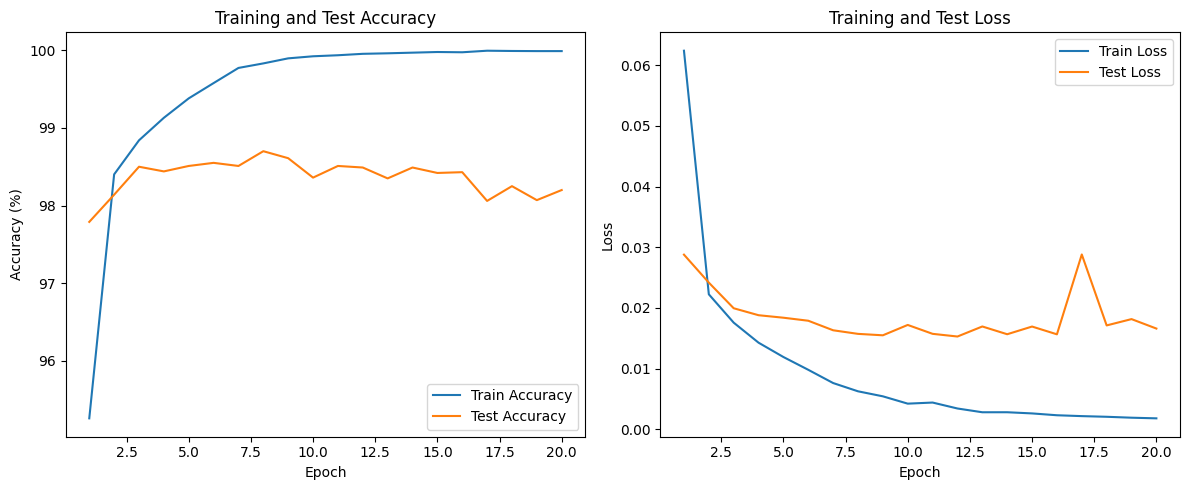

In [23]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs+1)
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

plt.tight_layout()
plt.show()


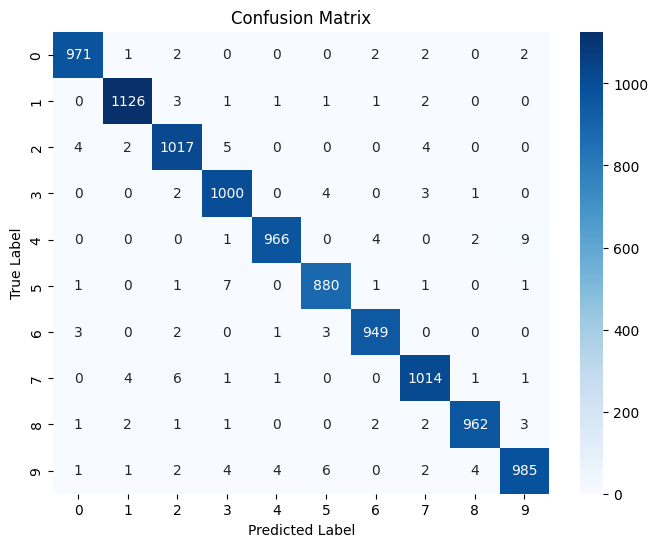

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.99      0.98      1032
           3       0.98      0.99      0.99      1010
           4       0.99      0.98      0.99       982
           5       0.98      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.98      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize



# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Classification Report (Precision, Recall, F1-Score)
print("Classification Report:\n")
print(classification_report(y_true, y_pred))



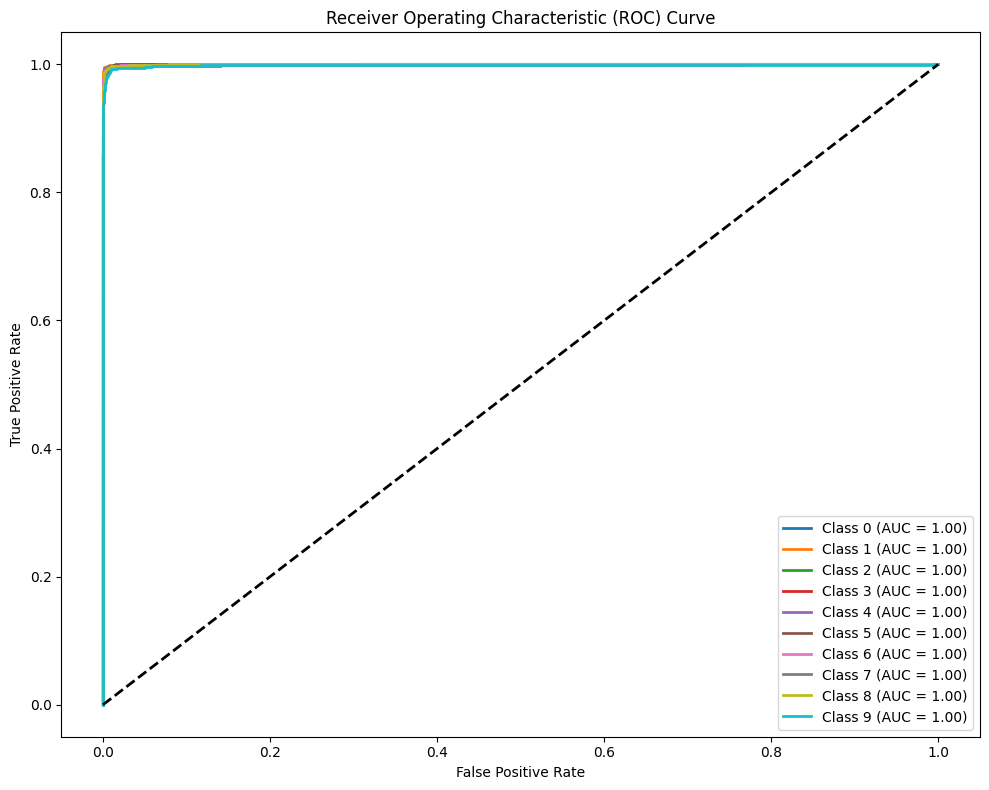

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import torch

# Assuming y_true contains the true labels and y_pred contains the predicted labels

def plot_roc_curve(y_true, y_score, num_classes=10):
    """Plot ROC curve for multi-class classification"""
    # Binarize the labels for multi-class classification
    y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))
    
    # Initialize a figure
    plt.figure(figsize=(10, 8))
    
    # Plot ROC curve for each class
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)  # Compute AUC
        plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')
    
    # Plot random chance line
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    
    # Set plot properties
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

# During your evaluation phase, get the predicted probabilities (not just the class predictions)
model.eval()
y_true = []
y_pred = []
y_score = []  # To store the predicted probabilities

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        # Get the model's output (predicted probabilities for each class)
        _, outputs = model(images)  # Outputs are [batch, 10] capsule lengths
        probabilities = F.softmax(outputs, dim=1)  # Apply softmax to get probabilities
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(outputs.argmax(dim=1).cpu().numpy())  # Class predictions
        y_score.extend(probabilities.cpu().numpy())  # Probabilities for ROC curve

# Now plot the ROC curve using the true labels and predicted probabilities
plot_roc_curve(np.array(y_true), np.array(y_score))
